<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap13_3_embeddings_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 13

## 13.3 Aprendizado por Transferência via Global Vectors (GloVe)

In [ ]:
#!pip install tensorflow-datasets
#!pip install keras
#!pip install tensorflow
!pip install -U gensim

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Embedding,Activation,SimpleRNN,BatchNormalization,RNN,Flatten,Input,LSTM,Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping
from keras.datasets import reuters
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import gensim
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Activation,Embedding,SimpleRNN,Dropout
from keras.utils.np_utils import to_categorical

In [ ]:
ds_train = tfds.load('snli', split='train[50%:]', shuffle_files=True)
ds_valid = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete9Z8GXP/snli-test.tfrecord*...:   0%|          | 0/10000 […

Generating validation examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete9Z8GXP/snli-validation.tfrecord*...:   0%|          | 0/1…

Generating train examples...:   0%|          | 0/550152 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete9Z8GXP/snli-train.tfrecord*...:   0%|          | 0/550152…

Dataset snli downloaded and prepared to ~/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [ ]:
def preprocessDataFrame(df):

    dic = {}
    dic['premise_hypothesis'] = []
    dic['label'] = []

    hypothesis = [x.decode('utf-8') for x in df['hypothesis'].values]
    premise = [x.decode('utf-8') for x in df['premise'].values]

    for idx,sentence in enumerate(premise):
        dic['premise_hypothesis'].append(premise[idx]+" "+hypothesis[idx])
        dic['label'].append(df['label'][idx])
        
    return pd.DataFrame.from_dict(dic)

In [ ]:
df_train = preprocessDataFrame(df_train)
df_valid = preprocessDataFrame(df_valid)
df_test = preprocessDataFrame(df_test)

In [ ]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [ ]:
train_tweets = df_train['premise_hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [ ]:
trunc_type = 'post'
padding_type = 'post'
max_length = 32
vocab_size = len(vocabulary)

In [ ]:
train_tweets = df_train['premise_hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['premise_hypothesis'])

word_index = tokenizer.word_index
print(f"{word_index['blue']} is the index of word 'blue'")
print(f"{word_index['launch']} is the index of word 'launch'")

train_sequences = tokenizer.texts_to_sequences(df_train['premise_hypothesis'])
valid_sequences = tokenizer.texts_to_sequences(df_valid['premise_hypothesis'])
test_sequences = tokenizer.texts_to_sequences(df_test['premise_hypothesis'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

30 is the index of word 'blue'
4478 is the index of word 'launch'


In [ ]:
import os
filename = 'glove.6B.100d.txt'
path_to_glove_file = os.path.join("glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 267975 word vectors.


In [ ]:
num_tokens = len(vocabulary) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 22813 words (5095 misses)


In [ ]:
from tensorflow import keras

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
model = Sequential()

model.add(Input(shape=(None,),dtype="int64"))
model.add(embedding_layer)

model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_padded, y_train, epochs=5, batch_size=64,
                    validation_data=(valid_padded, y_valid), verbose=1)

Epoch 1/5
4299/4299 [==============================] - 322s 74ms/step - loss: 0.9064 - accuracy: 0.5728 - val_loss: 0.8911 - val_accuracy: 0.6288
Epoch 2/5
4299/4299 [==============================] - 311s 72ms/step - loss: 0.7916 - accuracy: 0.6493 - val_loss: 0.8453 - val_accuracy: 0.6555
Epoch 3/5
4299/4299 [==============================] - 315s 73ms/step - loss: 0.7382 - accuracy: 0.6798 - val_loss: 0.8069 - val_accuracy: 0.6797
Epoch 4/5
4299/4299 [==============================] - 315s 73ms/step - loss: 0.6973 - accuracy: 0.7019 - val_loss: 0.7797 - val_accuracy: 0.6919
Epoch 5/5
4299/4299 [==============================] - 318s 74ms/step - loss: 0.6663 - accuracy: 0.7183 - val_loss: 0.7705 - val_accuracy: 0.6963


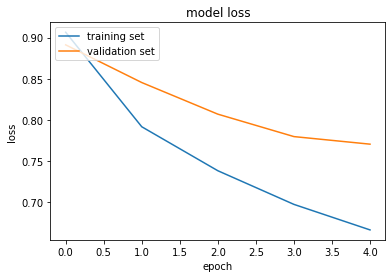

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.68      0.78      0.73      3368
           2       0.70      0.62      0.66      3219
           3       0.70      0.72      0.71      3237

    accuracy                           0.69     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.68      0.69      0.69     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
